# 操作1

In [204]:
%%HTML
<style>
    body {
        --vscode-font-family: 霞鹜文楷, Consolas, 'Courier New', monospace
    }
</style>

In [205]:
import warnings
warnings.filterwarnings('ignore')

In [206]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [207]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [208]:
from pts.model.time_grad import TimeGradEstimator
from pytorch_lightning import Trainer

In [209]:
from diffusers import DEISMultistepScheduler

In [210]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [211]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

# 数据准备

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.dataset.split import split
df = pd.read_csv(  "./mydata/diabetes.csv")
df_input = df[['timestamp', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']]
df_input = df_input.set_index('timestamp')

In [213]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
train_grouper_diabetes = MultivariateGrouper(max_target_dim=8)

test_grouper_diabetes = MultivariateGrouper( max_target_dim=8)

In [214]:
train_time='2020-02-27 04:12:53'
training_data = train_grouper_diabetes([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v1[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v2[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v3[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v4[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v5[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v6[:train_time]}],
     freq = "5min"
    )[0],ListDataset(
     [{"start": df_input.index[0], "target": df_input.v7[:train_time]}],
     freq = "5min"
    )[0],
])

In [215]:
test_data = test_grouper_diabetes([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v1[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v2[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v3[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v4[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v5[train_time:]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.v6[train_time:]}],
     freq = "5min"
    )[0],ListDataset(
     [{"start": df_input.index[0], "target": df_input.v7[train_time:]}],
     freq = "5min"
    )[0],
])

In [216]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [217]:
estimator_Diabetes = TimeGradEstimator(
    input_size=7,
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=12,
    context_length=36,
    freq='5min',
    scaling="mean",
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", devices="1"),
)


# 训练开始

In [218]:
predictor_Diabetes = estimator_Diabetes.train(training_data, num_workers=8)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


INFO: 
  | Name  | Type          | Params | Mode  | In sizes                                                         | Out sizes      
-------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 73.1 K | train | [[1, 1], [1, 1], [1, 36, 6], [1, 36, 7], [1, 36, 7], [1, 12, 6]] | [1, 100, 12, 7]
-------------------------------------------------------------------------------------------------------------------------------------
73.1 K    Trainable params
0         Non-trainable params
73.1 K    Total params
0.292     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type          | Params | Mode  | In sizes                                                         | Out sizes      
-------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 7

Epoch 0: |          | 50/? [00:04<00:00, 10.09it/s, v_num=25, train_loss=0.374]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.37353 (best 0.37353), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:04<00:00, 10.04it/s, v_num=25, train_loss=0.228]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.22800 (best 0.22800), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:04<00:00, 10.09it/s, v_num=25, train_loss=0.176]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 0.17558 (best 0.17558), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:04<00:00, 10.12it/s, v_num=25, train_loss=0.166]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 0.16620 (best 0.16620), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:04<00:00, 10.09it/s, v_num=25, train_loss=0.161]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 0.16058 (best 0.16058), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:04<00:00, 10.10it/s, v_num=25, train_loss=0.157]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300: 'train_loss' reached 0.15662 (best 0.15662), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:04<00:00, 10.00it/s, v_num=25, train_loss=0.149]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 350: 'train_loss' reached 0.14949 (best 0.14949), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:04<00:00, 10.08it/s, v_num=25, train_loss=0.145]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 400: 'train_loss' reached 0.14543 (best 0.14543), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:04<00:00, 11.51it/s, v_num=25, train_loss=0.141]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 450: 'train_loss' reached 0.14052 (best 0.14052), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:04<00:00, 11.79it/s, v_num=25, train_loss=0.137]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 500: 'train_loss' reached 0.13731 (best 0.13731), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:04<00:00, 11.75it/s, v_num=25, train_loss=0.134]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 550: 'train_loss' reached 0.13394 (best 0.13394), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:04<00:00, 11.83it/s, v_num=25, train_loss=0.132]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 600: 'train_loss' reached 0.13199 (best 0.13199), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:04<00:00, 11.85it/s, v_num=25, train_loss=0.130]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 650: 'train_loss' reached 0.13020 (best 0.13020), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:04<00:00, 11.61it/s, v_num=25, train_loss=0.123]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 700: 'train_loss' reached 0.12300 (best 0.12300), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:04<00:00, 11.76it/s, v_num=25, train_loss=0.122]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 750: 'train_loss' reached 0.12159 (best 0.12159), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:04<00:00, 11.80it/s, v_num=25, train_loss=0.121]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 800: 'train_loss' reached 0.12126 (best 0.12126), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:04<00:00, 11.75it/s, v_num=25, train_loss=0.119]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 850: 'train_loss' reached 0.11942 (best 0.11942), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:04<00:00, 11.91it/s, v_num=25, train_loss=0.119]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 900: 'train_loss' reached 0.11935 (best 0.11935), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:04<00:00, 11.88it/s, v_num=25, train_loss=0.114]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 950: 'train_loss' reached 0.11444 (best 0.11444), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:04<00:00, 11.46it/s, v_num=25, train_loss=0.113]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1000: 'train_loss' reached 0.11251 (best 0.11251), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:04<00:00, 11.64it/s, v_num=25, train_loss=0.117]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:04<00:00, 11.54it/s, v_num=25, train_loss=0.115]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:04<00:00, 11.69it/s, v_num=25, train_loss=0.111]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 1150: 'train_loss' reached 0.11121 (best 0.11121), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:04<00:00, 11.50it/s, v_num=25, train_loss=0.109]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 1200: 'train_loss' reached 0.10878 (best 0.10878), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:04<00:00, 11.96it/s, v_num=25, train_loss=0.111]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:04<00:00, 11.57it/s, v_num=25, train_loss=0.109]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:04<00:00, 11.39it/s, v_num=25, train_loss=0.107]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 1350: 'train_loss' reached 0.10656 (best 0.10656), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:04<00:00, 11.25it/s, v_num=25, train_loss=0.109]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:04<00:00, 11.73it/s, v_num=25, train_loss=0.107]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:04<00:00, 12.02it/s, v_num=25, train_loss=0.107]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:04<00:00, 12.04it/s, v_num=25, train_loss=0.105]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 1550: 'train_loss' reached 0.10472 (best 0.10472), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:04<00:00, 11.79it/s, v_num=25, train_loss=0.105]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:04<00:00, 11.86it/s, v_num=25, train_loss=0.104]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 1650: 'train_loss' reached 0.10362 (best 0.10362), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=32-step=1650.ckpt' as top 1


Epoch 33: |          | 50/? [00:04<00:00, 11.53it/s, v_num=25, train_loss=0.105]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:04<00:00, 11.40it/s, v_num=25, train_loss=0.102]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 1750: 'train_loss' reached 0.10183 (best 0.10183), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:04<00:00, 11.42it/s, v_num=25, train_loss=0.102]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:04<00:00, 11.27it/s, v_num=25, train_loss=0.103]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:04<00:00, 11.46it/s, v_num=25, train_loss=0.0986]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 1900: 'train_loss' reached 0.09859 (best 0.09859), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [00:04<00:00, 11.23it/s, v_num=25, train_loss=0.100] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:04<00:00, 10.93it/s, v_num=25, train_loss=0.0964]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 2000: 'train_loss' reached 0.09640 (best 0.09640), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:04<00:00, 11.62it/s, v_num=25, train_loss=0.0985]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:04<00:00, 11.26it/s, v_num=25, train_loss=0.0994]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:04<00:00, 11.58it/s, v_num=25, train_loss=0.0984]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:04<00:00, 11.39it/s, v_num=25, train_loss=0.101] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:04<00:00, 11.49it/s, v_num=25, train_loss=0.0993]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:04<00:00, 11.79it/s, v_num=25, train_loss=0.0975]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:04<00:00, 11.39it/s, v_num=25, train_loss=0.0988]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:04<00:00, 11.45it/s, v_num=25, train_loss=0.0976]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:04<00:00, 11.44it/s, v_num=25, train_loss=0.0959]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 2450: 'train_loss' reached 0.09591 (best 0.09591), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:04<00:00, 11.48it/s, v_num=25, train_loss=0.0957]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 2500: 'train_loss' reached 0.09568 (best 0.09568), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=49-step=2500.ckpt' as top 1


Epoch 50: |          | 50/? [00:04<00:00, 11.26it/s, v_num=25, train_loss=0.095] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 2550: 'train_loss' reached 0.09495 (best 0.09495), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=50-step=2550.ckpt' as top 1


Epoch 51: |          | 50/? [00:04<00:00, 11.37it/s, v_num=25, train_loss=0.0954]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [00:04<00:00, 11.35it/s, v_num=25, train_loss=0.0949]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 2650: 'train_loss' reached 0.09493 (best 0.09493), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=52-step=2650.ckpt' as top 1


Epoch 53: |          | 50/? [00:04<00:00, 11.28it/s, v_num=25, train_loss=0.0917]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 2700: 'train_loss' reached 0.09174 (best 0.09174), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=53-step=2700.ckpt' as top 1


Epoch 54: |          | 50/? [00:04<00:00, 11.33it/s, v_num=25, train_loss=0.0914]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 2750: 'train_loss' reached 0.09141 (best 0.09141), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=54-step=2750.ckpt' as top 1


Epoch 55: |          | 50/? [00:04<00:00, 11.31it/s, v_num=25, train_loss=0.0943]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: |          | 50/? [00:04<00:00, 11.18it/s, v_num=25, train_loss=0.0928]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [00:04<00:00, 11.27it/s, v_num=25, train_loss=0.0901]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 2900: 'train_loss' reached 0.09015 (best 0.09015), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=57-step=2900.ckpt' as top 1


Epoch 58: |          | 50/? [00:04<00:00, 11.30it/s, v_num=25, train_loss=0.0932]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [00:04<00:00, 11.22it/s, v_num=25, train_loss=0.090] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 3000: 'train_loss' reached 0.08999 (best 0.08999), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=59-step=3000.ckpt' as top 1


Epoch 60: |          | 50/? [00:04<00:00, 11.15it/s, v_num=25, train_loss=0.0891]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 3050: 'train_loss' reached 0.08906 (best 0.08906), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=60-step=3050.ckpt' as top 1


Epoch 61: |          | 50/? [00:04<00:00, 11.46it/s, v_num=25, train_loss=0.0898]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [00:04<00:00, 11.41it/s, v_num=25, train_loss=0.0889]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 3150: 'train_loss' reached 0.08894 (best 0.08894), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=62-step=3150.ckpt' as top 1


Epoch 63: |          | 50/? [00:04<00:00, 11.31it/s, v_num=25, train_loss=0.0913]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: |          | 50/? [00:04<00:00, 11.58it/s, v_num=25, train_loss=0.0851]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 3250: 'train_loss' reached 0.08510 (best 0.08510), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=64-step=3250.ckpt' as top 1


Epoch 65: |          | 50/? [00:04<00:00, 11.31it/s, v_num=25, train_loss=0.0938]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |          | 50/? [00:04<00:00, 11.20it/s, v_num=25, train_loss=0.0879]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |          | 50/? [00:04<00:00, 11.22it/s, v_num=25, train_loss=0.0939]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |          | 50/? [00:04<00:00, 11.28it/s, v_num=25, train_loss=0.0889]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: |          | 50/? [00:04<00:00, 11.24it/s, v_num=25, train_loss=0.0872]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: |          | 50/? [00:04<00:00, 11.26it/s, v_num=25, train_loss=0.0871]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [00:04<00:00, 11.25it/s, v_num=25, train_loss=0.0873]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: |          | 50/? [00:04<00:00, 11.38it/s, v_num=25, train_loss=0.0887]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |          | 50/? [00:04<00:00, 11.19it/s, v_num=25, train_loss=0.0847]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 3700: 'train_loss' reached 0.08468 (best 0.08468), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=73-step=3700.ckpt' as top 1


Epoch 74: |          | 50/? [00:04<00:00, 11.41it/s, v_num=25, train_loss=0.0863]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |          | 50/? [00:04<00:00, 11.42it/s, v_num=25, train_loss=0.0859]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |          | 50/? [00:04<00:00, 11.48it/s, v_num=25, train_loss=0.0862]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: |          | 50/? [00:04<00:00, 11.57it/s, v_num=25, train_loss=0.0862]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [00:04<00:00, 11.33it/s, v_num=25, train_loss=0.0845]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 3950: 'train_loss' reached 0.08452 (best 0.08452), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=78-step=3950.ckpt' as top 1


Epoch 79: |          | 50/? [00:04<00:00, 11.54it/s, v_num=25, train_loss=0.0861]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |          | 50/? [00:04<00:00, 11.42it/s, v_num=25, train_loss=0.0868]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: |          | 50/? [00:04<00:00, 11.63it/s, v_num=25, train_loss=0.088] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: |          | 50/? [00:04<00:00, 11.44it/s, v_num=25, train_loss=0.0838]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 4150: 'train_loss' reached 0.08379 (best 0.08379), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=82-step=4150.ckpt' as top 1


Epoch 83: |          | 50/? [00:04<00:00, 11.69it/s, v_num=25, train_loss=0.0844]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: |          | 50/? [00:04<00:00, 11.59it/s, v_num=25, train_loss=0.0839]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: |          | 50/? [00:04<00:00, 11.40it/s, v_num=25, train_loss=0.0851]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |          | 50/? [00:04<00:00, 11.38it/s, v_num=25, train_loss=0.0819]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 4350: 'train_loss' reached 0.08194 (best 0.08194), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=86-step=4350.ckpt' as top 1


Epoch 87: |          | 50/? [00:04<00:00, 11.32it/s, v_num=25, train_loss=0.0827]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: |          | 50/? [00:04<00:00, 11.30it/s, v_num=25, train_loss=0.0848]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: |          | 50/? [00:04<00:00, 11.43it/s, v_num=25, train_loss=0.083] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: |          | 50/? [00:04<00:00, 11.33it/s, v_num=25, train_loss=0.0812]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 4550: 'train_loss' reached 0.08116 (best 0.08116), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=90-step=4550.ckpt' as top 1


Epoch 91: |          | 50/? [00:04<00:00, 11.67it/s, v_num=25, train_loss=0.0829]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |          | 50/? [00:04<00:00, 11.69it/s, v_num=25, train_loss=0.085] 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: |          | 50/? [00:04<00:00, 11.64it/s, v_num=25, train_loss=0.0794]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 4700: 'train_loss' reached 0.07944 (best 0.07944), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=93-step=4700.ckpt' as top 1


Epoch 94: |          | 50/? [00:04<00:00, 11.60it/s, v_num=25, train_loss=0.0822]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: |          | 50/? [00:04<00:00, 11.36it/s, v_num=25, train_loss=0.0798]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |          | 50/? [00:04<00:00, 11.62it/s, v_num=25, train_loss=0.0771]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 4850: 'train_loss' reached 0.07715 (best 0.07715), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_25/checkpoints/epoch=96-step=4850.ckpt' as top 1


Epoch 97: |          | 50/? [00:04<00:00, 11.64it/s, v_num=25, train_loss=0.0811]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |          | 50/? [00:04<00:00, 11.73it/s, v_num=25, train_loss=0.0796]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: |          | 50/? [00:04<00:00, 11.54it/s, v_num=25, train_loss=0.0803]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 5000: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:04<00:00, 11.39it/s, v_num=25, train_loss=0.0803]


In [219]:
forecast_it_Diabetes, ts_it_Diabetes = make_evaluation_predictions(dataset=test_data,
                                                 predictor=predictor_Diabetes,
                                                 num_samples=100)


In [220]:
forecasts_Diabetes = list(forecast_it_Diabetes)
targets_Diabetes = list(ts_it_Diabetes)

In [221]:
len(forecasts_Diabetes)

1

In [222]:
train_time

'2020-02-27 04:12:53'

In [223]:
forecasts_Diabetes[0].samples[1]

array([[-8.4147692e-01,  2.5804842e-01,  1.4201304e-01, -2.8808716e-01,
        -4.7101536e-01,  2.6799926e-01, -5.1391447e-01],
       [-3.2352123e-02,  4.2727746e-02, -2.6372077e-02,  1.8610500e-02,
         2.8921941e-02, -3.9269533e-02, -1.0325172e+00],
       [-9.8095667e-01,  2.9034469e-01,  2.1187851e-01, -2.5912228e-01,
        -6.1045474e-01,  3.0600622e-01, -7.0502895e-01],
       [-4.8335555e-01,  3.1127613e-02,  2.3201059e-01, -5.3486979e-01,
         1.8508965e-02, -9.3803346e-02, -7.8087538e-01],
       [-3.8064623e-01,  1.8400319e-01,  5.8096206e-01, -3.7871489e-01,
        -3.5186929e-01, -2.5511384e-01, -1.0010595e+00],
       [-2.6112166e-01,  2.6790923e-01,  4.2130062e-01, -7.7822581e-02,
         6.4942323e-02,  1.3140781e-01, -8.6985523e-01],
       [-2.7704528e-01,  2.0226449e-02,  2.8077182e-01, -3.7209931e-01,
         6.3720724e-04,  2.1134846e-01, -1.0993819e+00],
       [-1.0201104e-01,  5.4690737e-02,  2.3710321e-01, -3.4244332e-01,
        -3.6239877e-01,  

# 画出预测图

Diabetes


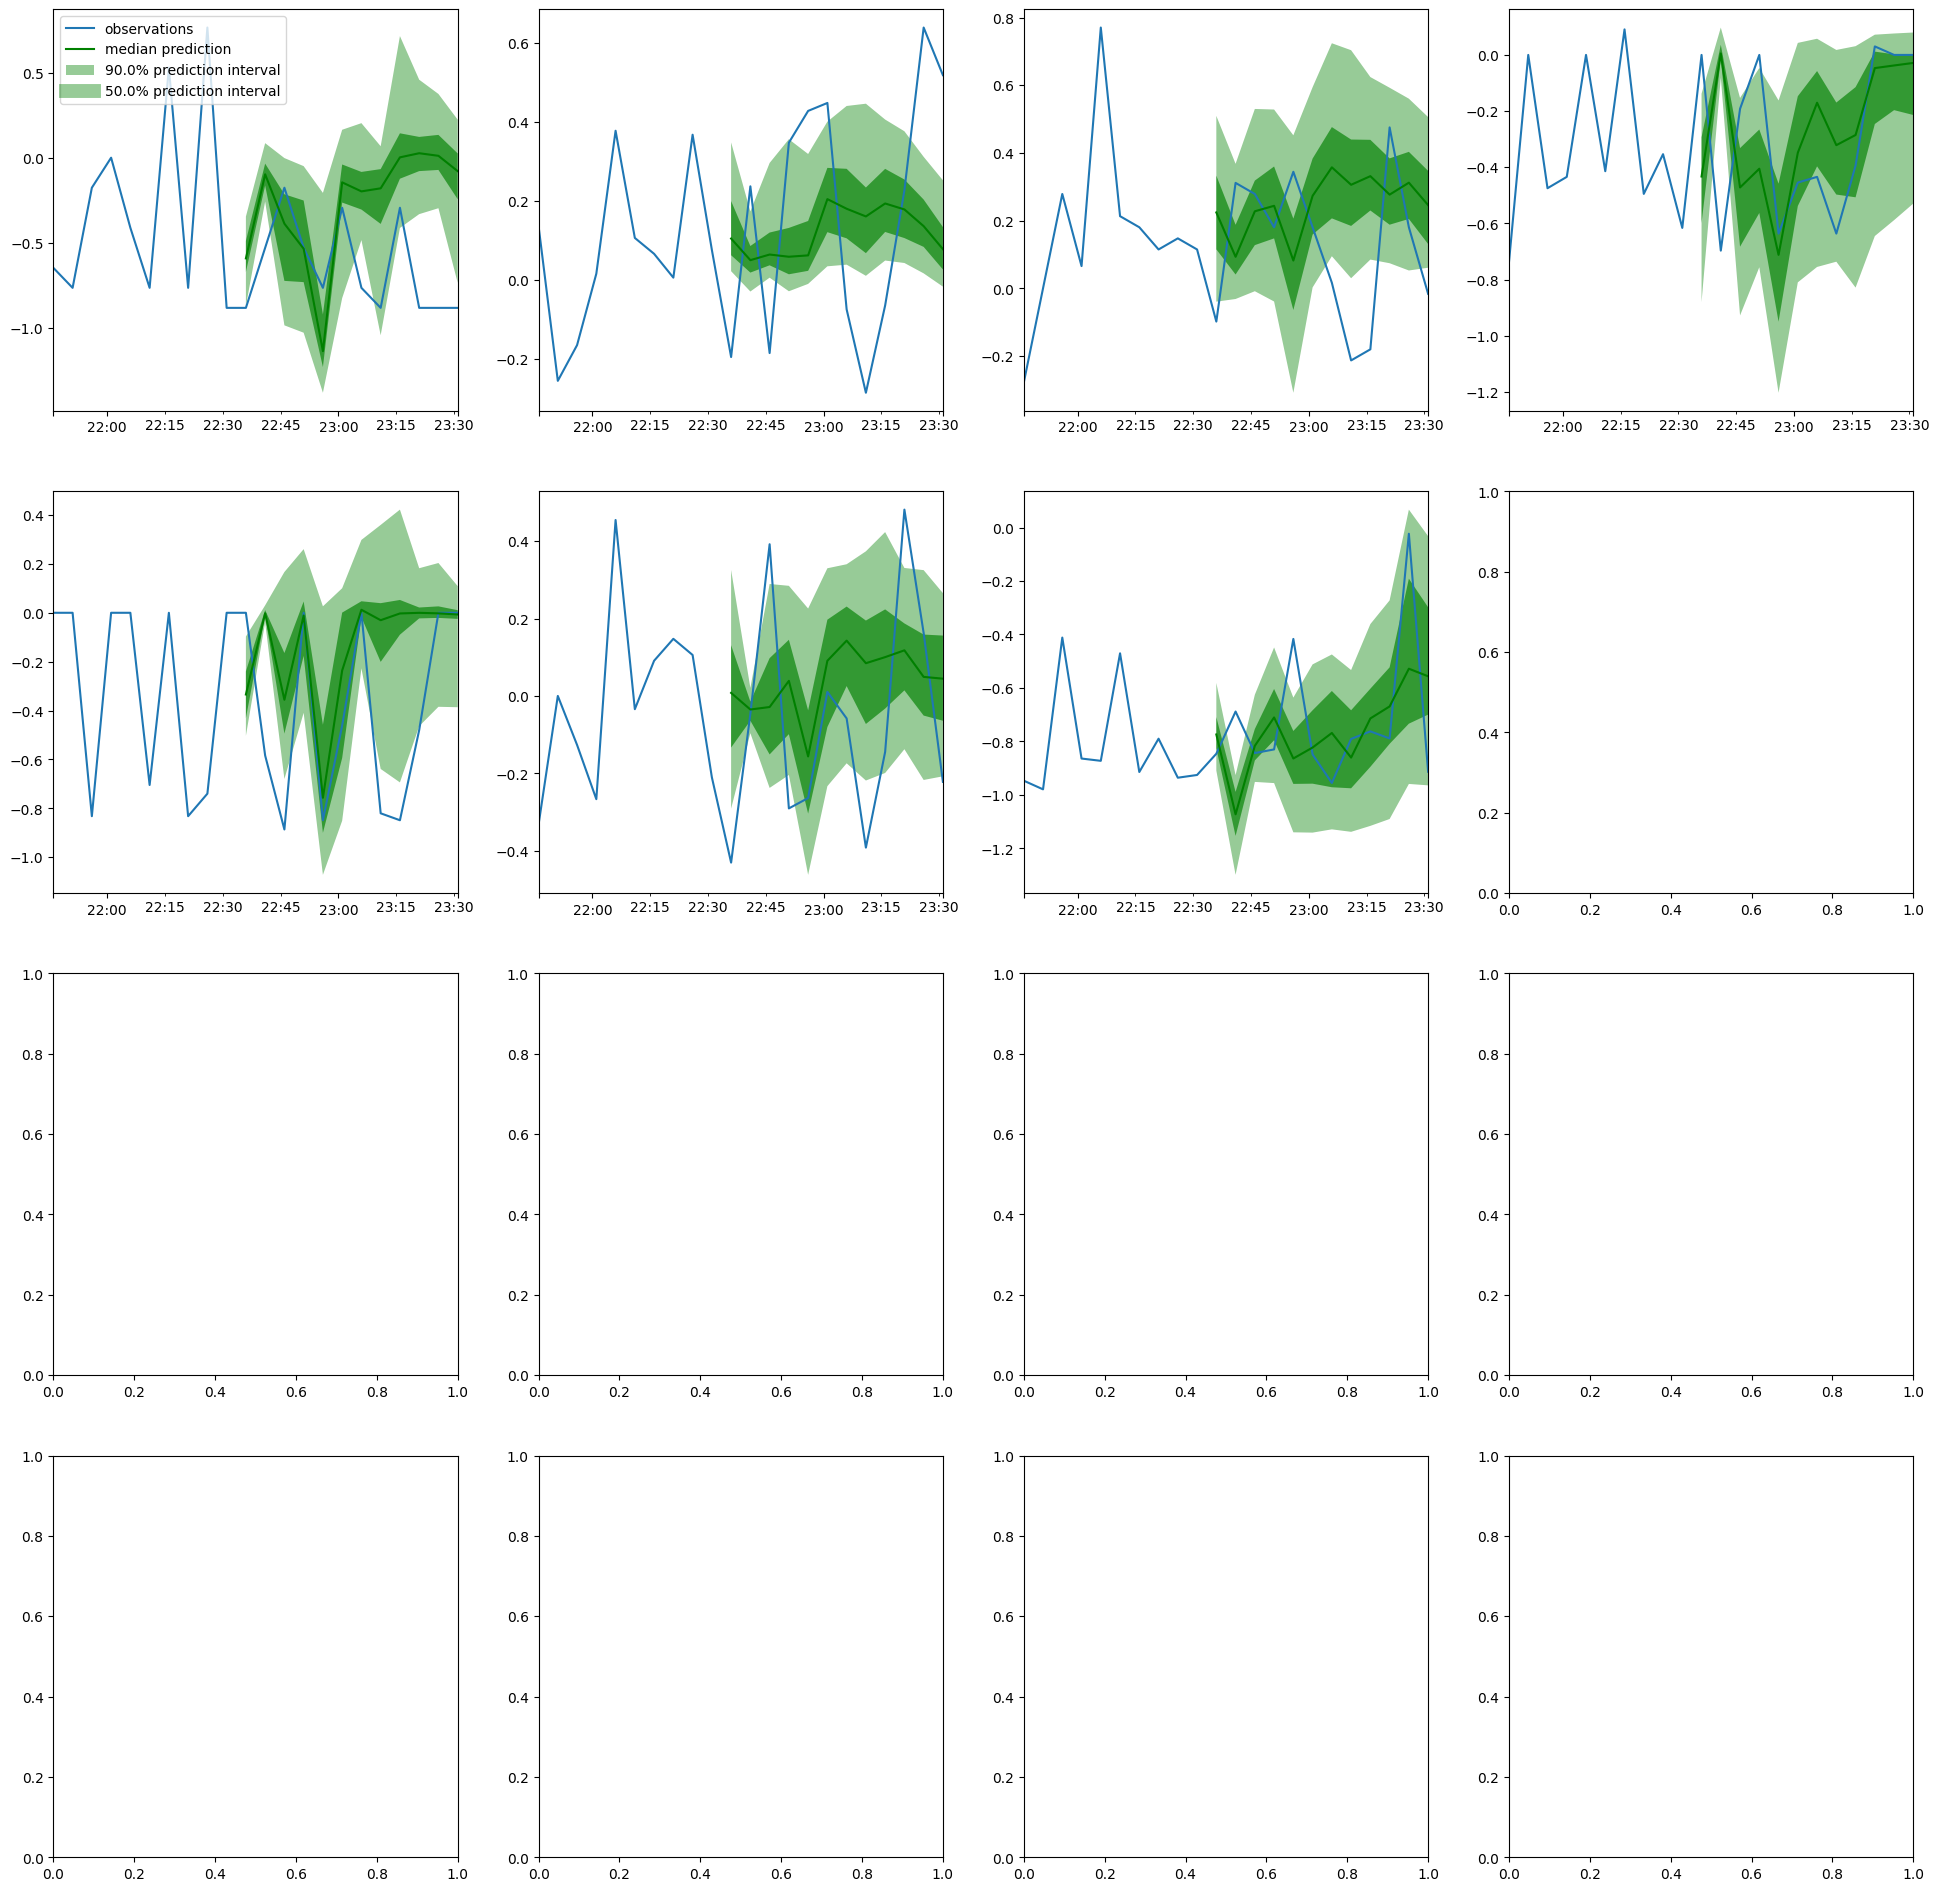

In [224]:
print("Diabetes")

plot(
    target=targets_Diabetes[0],
    forecast=forecasts_Diabetes[0],
    prediction_length=12,
)
plt.show()

# 评估

In [225]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [226]:
agg_metric_Diabetes, item_metrics_Diabetes = evaluator(targets_Diabetes, forecasts_Diabetes, num_series=len(test_data))


Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 1it [00:00, 45.20it/s]
Running evaluation: 1it [00:00, 106.03it/s]
Running evaluation: 1it [00:00, 102.87it/s]
Running evaluation: 1it [00:00, 108.82it/s]
Running evaluation: 1it [00:00, 109.12it/s]
Running evaluation: 1it [00:00, 116.34it/s]
Running evaluation: 1it [00:00, 120.94it/s]
Running evaluation: 1it [00:00, 95.59it/s]


In [227]:
print("Diabetes Results")
print("CRPS:", agg_metric_Diabetes["mean_wQuantileLoss"])
print("ND:", agg_metric_Diabetes["ND"])
print("NRMSE:", agg_metric_Diabetes["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_Diabetes["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_Diabetes["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_Diabetes["m_sum_NRMSE"])

Diabetes Results
CRPS: 0.5821449269054925
ND: 0.7185061960985094
NRMSE: 0.8992133557247893

CRPS-Sum: 0.47691407380060574
ND-Sum: 0.5985906878061926
NRMSE-Sum: 0.7395682532537594
